In [1]:
#import pandas as pd
import numpy as np
import os
import sys
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow_io as tfio
import keras
from keras.models import Sequential
import tensorflow_io as tfio
import warnings
import glob
from keras.callbacks import ModelCheckpoint
import pydash
#from pypesq import pesq
import soundfile as sf
from skimage.metrics import structural_similarity as ssim


In [2]:
sr=8000
speech_length_pix_sec=27e-3
total_length = 3.6
trim_length = 28400
n_fft=255
frame_length=255
frame_step = 110
arquivo = os.path.join('..','..','bases_vozes','urbansound_8k')
noisefiles = glob.glob(arquivo+os.path.sep+'*.wav')
files = glob.glob('../../bases_vozes/Base_Vozes_IFPB/banco de vozes_mono/vozes_nome/Vozes Mono/**/*.wav')
#files = glob.glob('../bases_vozes/RAVDESS_8k/**/*.wav')
print(len(files),'clean data files')
# print('Should be similar value to trim length', total_length*sr,trim_length)
# print('Should be similar value to n_fft',n_fft, int(speech_length_pix_sec*sr))

91 clean data files


In [3]:
@tf.function
def load_wav(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=sr)
    return wav

@tf.function
def preprocess_tf(filepath):
    wav = load_wav(filepath)
    wav = tf.concat([wav, wav, wav], 0)
    wav = wav[:trim_length]
    zero_padding = tf.zeros([trim_length] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    return wav

@tf.function
def white_noise(data,factor=0.03):
    noise_amp = factor*tf.reduce_max(data)*tf.random.normal(shape=(1,))
    corr_data = data + noise_amp*tf.random.normal(shape=tf.shape(data))
    return corr_data, data

@tf.function
def urban_noise(corr_data, data, factor=0.4,sr=sr):
    noisefile = tf.gather(noisefiles,tf.random.uniform((),0, len(noisefiles)-1,dtype=tf.int32))
    noisefile  = load_wav(noisefile)
    mixed = noisefile * factor * tf.reduce_max(corr_data)/tf.reduce_max(noisefile) + corr_data 
    return mixed, data

@tf.function
def convert_to_spectrogram(wav_corr, wavclean):
    spectrogram_corr = tf.signal.stft(wav_corr, frame_length=frame_length, fft_length=n_fft,
                                      frame_step=frame_step)
    spectrogram = tf.signal.stft(wavclean, frame_length=frame_length, fft_length=n_fft,
                                      frame_step=frame_step)
    return spectrogram_corr, spectrogram

@tf.function
def spectrogram_abs(spectrogram_corr, spectrogram):
    spectrogram = tf.abs(spectrogram)
    spectrogram_corr = tf.abs(spectrogram_corr)
    return spectrogram_corr, spectrogram

@tf.function
def augment(spectrogram_corr, spectrogram):
    spectrogram_corr = tfio.audio.freq_mask(spectrogram_corr, 10)
    spectrogram_corr = tfio.audio.time_mask(spectrogram_corr, 20)
    return spectrogram_corr, spectrogram

@tf.function
def expand_dims(spectrogram_corr, spectrogram):
    spectrogram_corr = tf.expand_dims(spectrogram_corr, axis=2)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram_corr, spectrogram

@tf.function
def tf_resize(t, shape):
    """
    Args:
      t: a `Tensor`
      shape: requested output shape
    """
    print(t.shape)
    input_size = tf.size(t)
    output_size = tf.reduce_prod(shape)
    t_flatten = tf.reshape(t, [input_size])
    result = tf.tile(t_flatten, [output_size // input_size + 1])
    print(result[0])
    #result = tf.reshape(result[0:output_size], shape=shape)
    return result, t_flatten, result

In [4]:
choose_audio = files[1]
Audio(f'{choose_audio}', rate=8000)

In [5]:
sinal_voz, fs = librosa.load(choose_audio, sr=8000)
Ts=1/fs

print(f'Frequência: {fs}Hz')
print(f'Amostras: {len(sinal_voz)}')
print(f'Duração do sinal: {len(sinal_voz)/fs}s')

Frequência: 8000Hz
Amostras: 7446
Duração do sinal: 0.93075s


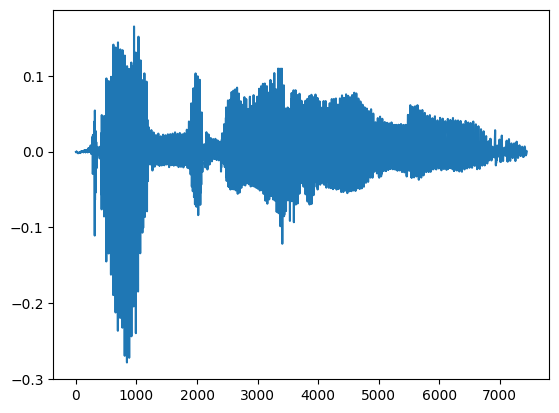

In [6]:
plt.plot(sinal_voz)

In [7]:
sinal_processado = preprocess_tf(choose_audio)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


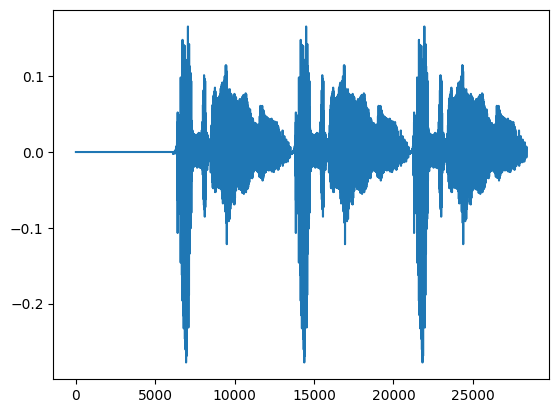

In [8]:
plt.plot(sinal_processado)

In [9]:
print(f'Duração do sinal: {len(sinal_processado)/fs}s')

Duração do sinal: 3.55s


In [10]:
sf.write('teste.wav',sinal_processado,sr)

In [11]:
choose_audio = noisefiles[3]
Audio(f'{choose_audio}', rate=8000)

In [12]:
sinal, fs = librosa.load(choose_audio, sr=8000)
Ts=1/fs

print(f'Frequência: {fs}Hz')
print(f'Amostras: {len(sinal)}')
print(f'Duração do sinal: {len(sinal)/fs}s')

Frequência: 8000Hz
Amostras: 28400
Duração do sinal: 3.55s


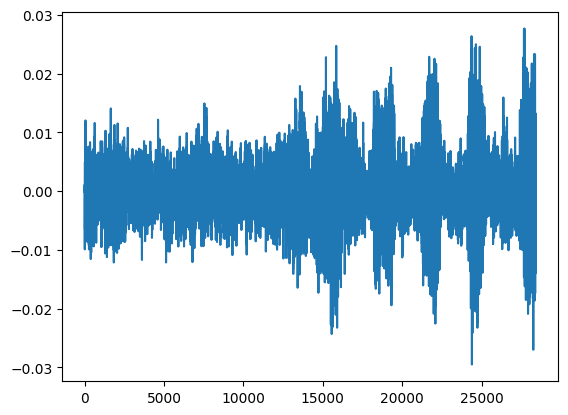

In [13]:
plt.plot(sinal)

# Criação do dataset

In [14]:
batch_size=16
train_val_split_ratio = 0.2
split_index = int(len(files)*train_val_split_ratio)
train_files = files[split_index:]
val_files = files[:split_index]

def configure_dataset(files, train=True):
    dataset = tf.data.Dataset.from_tensor_slices(files)
    dataset = dataset.map(preprocess_tf, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(white_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(urban_noise, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.map(convert_to_spectrogram, num_parallel_calls=tf.data.AUTOTUNE)
    if not train:
        dataset = dataset.map(expand_dims, num_parallel_calls=tf.data.AUTOTUNE)

    if train:
        dataset = dataset.map(spectrogram_abs, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(expand_dims, num_parallel_calls=tf.data.AUTOTUNE)
        
        dataset = dataset.batch(batch_size)
        dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [15]:
train_dataset = configure_dataset(train_files)
val_dataset = configure_dataset(val_files)

In [16]:
train_ds = train_dataset.unbatch()
images = list(train_ds.map(lambda x, y: x))
labels = list(train_ds.map(lambda x, y: y))

print(len(labels))
print(len(images))

73
73


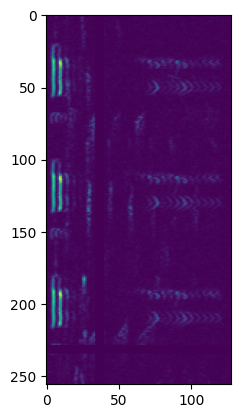

In [17]:
plt.imshow(images[72])

In [18]:
len(train_files)

73

In [19]:
len(val_files)

18

# Arquitetura da rede

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    Dropout,
    SpatialDropout2D,
    UpSampling2D,
    Input,
    concatenate,
    multiply,
    add,
    Activation,
)


def upsample_conv(filters, kernel_size, strides, padding):
    return Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)


def upsample_simple(filters, kernel_size, strides, padding):
    return UpSampling2D(strides)


def attention_gate(inp_1, inp_2, n_intermediate_filters):
    """Attention gate. Compresses both inputs to n_intermediate_filters filters before processing.
       Implemented as proposed by Oktay et al. in their Attention U-net, see: https://arxiv.org/abs/1804.03999.
    """
    inp_1_conv = Conv2D(
        n_intermediate_filters,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(inp_1)
    inp_2_conv = Conv2D(
        n_intermediate_filters,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(inp_2)

    f = Activation("relu")(add([inp_1_conv, inp_2_conv]))
    g = Conv2D(
        filters=1,
        kernel_size=1,
        strides=1,
        padding="same",
        kernel_initializer="he_normal",
    )(f)
    h = Activation("sigmoid")(g)
    return multiply([inp_1, h])


def attention_concat(conv_below, skip_connection):
    """Performs concatenation of upsampled conv_below with attention gated version of skip-connection
    """
    below_filters = conv_below.get_shape().as_list()[-1]
    attention_across = attention_gate(skip_connection, conv_below, below_filters)
    return concatenate([conv_below, attention_across])


def conv2d_block(
    inputs,
    use_batch_norm=True,
    dropout=0.3,
    dropout_type="spatial",
    filters=16,
    kernel_size=(3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="same",
):

    if dropout_type == "spatial":
        DO = SpatialDropout2D
    elif dropout_type == "standard":
        DO = Dropout
    else:
        raise ValueError(
            f"dropout_type must be one of ['spatial', 'standard'], got {dropout_type}"
        )

    c = Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(inputs)
    if use_batch_norm:
        c = BatchNormalization()(c)
    if dropout > 0.0:
        c = DO(dropout)(c)
    c = Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm,
    )(c)
    if use_batch_norm:
        c = BatchNormalization()(c)
    return c


def custom_unet(
    input_shape,
    num_classes=1,
    activation="relu",
    use_batch_norm=True,
    upsample_mode="deconv",  # 'deconv' or 'simple'
    dropout=0.3,
    dropout_change_per_layer=0.0,
    dropout_type="spatial",
    use_dropout_on_upsampling=False,
    use_attention=False,
    filters=16,
    num_layers=4,
    output_activation="sigmoid",
):  # 'sigmoid' or 'softmax'

    if upsample_mode == "deconv":
        upsample = upsample_conv
    else:
        upsample = upsample_simple

    # Build U-Net model
    inputs = Input(input_shape)
    inputs_copy = tf.identity(inputs)
    x = inputs / tf.reduce_max(inputs)

    down_layers = []
    for l in range(num_layers):
        x = conv2d_block(
            inputs=x,
            filters=filters,
            use_batch_norm=use_batch_norm,
            dropout=dropout,
            dropout_type=dropout_type,
            activation=activation,
        )
        down_layers.append(x)
        x = MaxPooling2D((2, 2))(x)
        dropout += dropout_change_per_layer
        filters = filters * 2  # double the number of filters with each layer

    x = conv2d_block(
        inputs=x,
        filters=filters,
        use_batch_norm=use_batch_norm,
        dropout=dropout,
        dropout_type=dropout_type,
        activation=activation,
    )

    if not use_dropout_on_upsampling:
        dropout = 0.0
        dropout_change_per_layer = 0.0

    for conv in reversed(down_layers):
        filters //= 2  # decreasing number of filters with each layer
        dropout -= dropout_change_per_layer
        x = upsample(filters, (2, 2), strides=(2, 2), padding="same")(x)
        if use_attention:
            x = attention_concat(conv_below=x, skip_connection=conv)
        else:
            x = concatenate([x, conv])
        x = conv2d_block(
            inputs=x,
            filters=filters,
            use_batch_norm=use_batch_norm,
            dropout=dropout,
            dropout_type=dropout_type,
            activation=activation,
        )

    output_mask = Conv2D(num_classes, (1, 1), activation=output_activation)(x)
    outputs = keras.layers.Multiply()([output_mask, inputs_copy])
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

## Transfer Learning

In [21]:
model = custom_unet(
    input_shape=(256, 128, 1),
    use_batch_norm=True,
    num_classes=1,
    filters=16, 
    num_layers=4,
    dropout=0.2,
    output_activation='sigmoid')

model_filename = 'model_weights.h5'
callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='val_loss',
    save_weights_only=True,
    save_best_only=True)

callback_early_stop =tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    mode="auto",
    restore_best_weights=True,
)

def signal_enhancement_loss(y_true, y_pred):
    mae = tf.abs(y_true - y_pred)
    speech_loss =  2 * tf.abs(y_true**2 - y_pred*y_true)
    return tf.reduce_mean(mae, axis=-1) + tf.reduce_mean(speech_loss, axis=-1)

model.compile(optimizer='adam', loss=signal_enhancement_loss)
model.load_weights('modelos/speech_mask_model/new_model_weights.h5')

# Evaluation

In [22]:
trim_length = 28305
files_to_test = val_files
test_dataset = configure_dataset(files_to_test,train=False)
num = test_dataset.as_numpy_iterator()
mae = tf.keras.losses.MeanAbsoluteError()

In [23]:
pesq_with_noise = np.zeros(len(files_to_test))
pesq_denoised = np.zeros(len(files_to_test))

wav_clean_array =  np.zeros((len(files_to_test),trim_length))
wav_corrupt_array =  np.zeros((len(files_to_test),trim_length))
wav_correct_array =  np.zeros((len(files_to_test),trim_length))
spec_clean_array=  np.zeros((len(files_to_test), 256, 128))
spec_corrupt_array=  np.zeros((len(files_to_test), 256, 128))
spec_correct_array=  np.zeros((len(files_to_test), 256, 128))
loss_with_noise = np.zeros(len(files_to_test))
loss_denoised = np.zeros(len(files_to_test))
ssim_clean_correct = []
ssim_clean_corrupt = []


for ind in range(len(files_to_test)):
    corr, clean = num.next()
    corr_wav = tf.signal.inverse_stft(corr[:,:,0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)
    clean_wav = tf.signal.inverse_stft(clean[:,:,0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step)
    corr_amp = np.abs(corr)
    corrected_amp = model.predict(np.expand_dims(corr_amp,0))
    corrected_spec = corrected_amp * np.exp(1j*np.angle(np.expand_dims(corr,0)))
    corrected_wav = tf.signal.inverse_stft(corrected_spec[0,:,:,0], frame_length=frame_length, fft_length=n_fft, frame_step=frame_step) 
           
    #pesq_with_noise[ind] = pesq(clean_wav,corr_wav,sr)
    #pesq_denoised[ind] = pesq(clean_wav,corrected_wav,sr)
    wav_clean_array[ind] = clean_wav
    wav_corrupt_array[ind] = corr_wav
    wav_correct_array[ind] = corrected_wav
    spec_clean_array[ind] = np.abs(clean[:,:,0])
    spec_corrupt_array[ind] = np.abs(corr[:,:,0])
    spec_correct_array[ind] = corrected_amp[0,:,:,0]
    ssim_clean_correct.append(ssim(spec_clean_array[ind],spec_correct_array[ind]))
    ssim_clean_corrupt.append(ssim(spec_clean_array[ind],spec_corrupt_array[ind]))
    loss_with_noise[ind] = tf.reduce_mean(signal_enhancement_loss(np.abs(clean), corr_amp)).numpy()
    loss_denoised[ind] =tf.reduce_mean(signal_enhancement_loss(np.abs(clean[:,:,0]), corrected_amp[0,:,:,0])).numpy()

#pesq_diff = pesq_denoised - pesq_with_noise

#print(np.mean(pesq_with_noise), np.mean(pesq_denoised),pesq_diff.mean())

#f'{np.mean(pesq_with_noise):.2f}, {np.mean(pesq_denoised):.2f}'

1/1 [==============================] - 0s 132ms/step


plt.specgram(np.log10(np.exp(-9)+wav_corrupt_array[0]))
plt.show()

In [24]:
list(enumerate(ssim_clean_corrupt))

[(0, 0.6612859110510398),
 (1, 0.5488646564000249),
 (2, 0.5885142708344716),
 (3, 0.3521714040104575),
 (4, 0.7138466177533562),
 (5, 0.5032863451900152),
 (6, 0.43935188752638354),
 (7, 0.6153322919954292),
 (8, 0.7610818418481636),
 (9, 0.511917106843165),
 (10, 0.6977087465986158),
 (11, 0.46236767543786506),
 (12, 0.20749160087433066),
 (13, 0.24969041514626997),
 (14, 0.17262129657129185),
 (15, 0.2635873084331981),
 (16, 0.2107056586241771),
 (17, 0.37850541886195865)]

In [25]:
list(enumerate(ssim_clean_correct))

[(0, 0.8515976423281155),
 (1, 0.7649779841047538),
 (2, 0.6338620715771335),
 (3, 0.6577850608189187),
 (4, 0.8292128752083832),
 (5, 0.7146363447994516),
 (6, 0.6330974199370154),
 (7, 0.7127606879238375),
 (8, 0.835998637347298),
 (9, 0.6989567923431405),
 (10, 0.7865628568978804),
 (11, 0.8225995092898439),
 (12, 0.742940169737125),
 (13, 0.8209611147498614),
 (14, 0.7543564702917904),
 (15, 0.6827798108353166),
 (16, 0.7199732143270319),
 (17, 0.8404240769765169)]

In [27]:
def maximo(lista):
    
    maior_valor = None
    maior_ind = None
    
    for ind, num in list(enumerate(lista)):
        if(maior_valor is None or num > maior_valor):
            maior_valor = num
            maior_ind = ind
    
    return maior_ind, maior_valor

In [35]:
def minimo(lista):
    
    menor_valor = None
    menor_ind = None
    
    for ind, num in list(enumerate(lista)):
        if(menor_valor is None or num < menor_valor):
            menor_valor = num
            menor_ind = ind
    
    return menor_ind, menor_valor

In [48]:
melhor_ind_correct, melhor_val_correct = maximo(ssim_clean_correct)

In [49]:
pior_ind_correct, pior_val_correct = minimo(ssim_clean_correct)

In [53]:
melhor_ind_corrupt, melhor_val_corrupt = maximo(ssim_clean_corrupt)

In [54]:
pior_ind_corrupt, pior_val_corrupt = minimo(ssim_clean_corrupt)

In [50]:
print(melhor_ind_correct,pior_ind_correct)

0 6


In [55]:
print(melhor_ind_corrupt,pior_ind_corrupt)

8 14


# Melhor Índice 

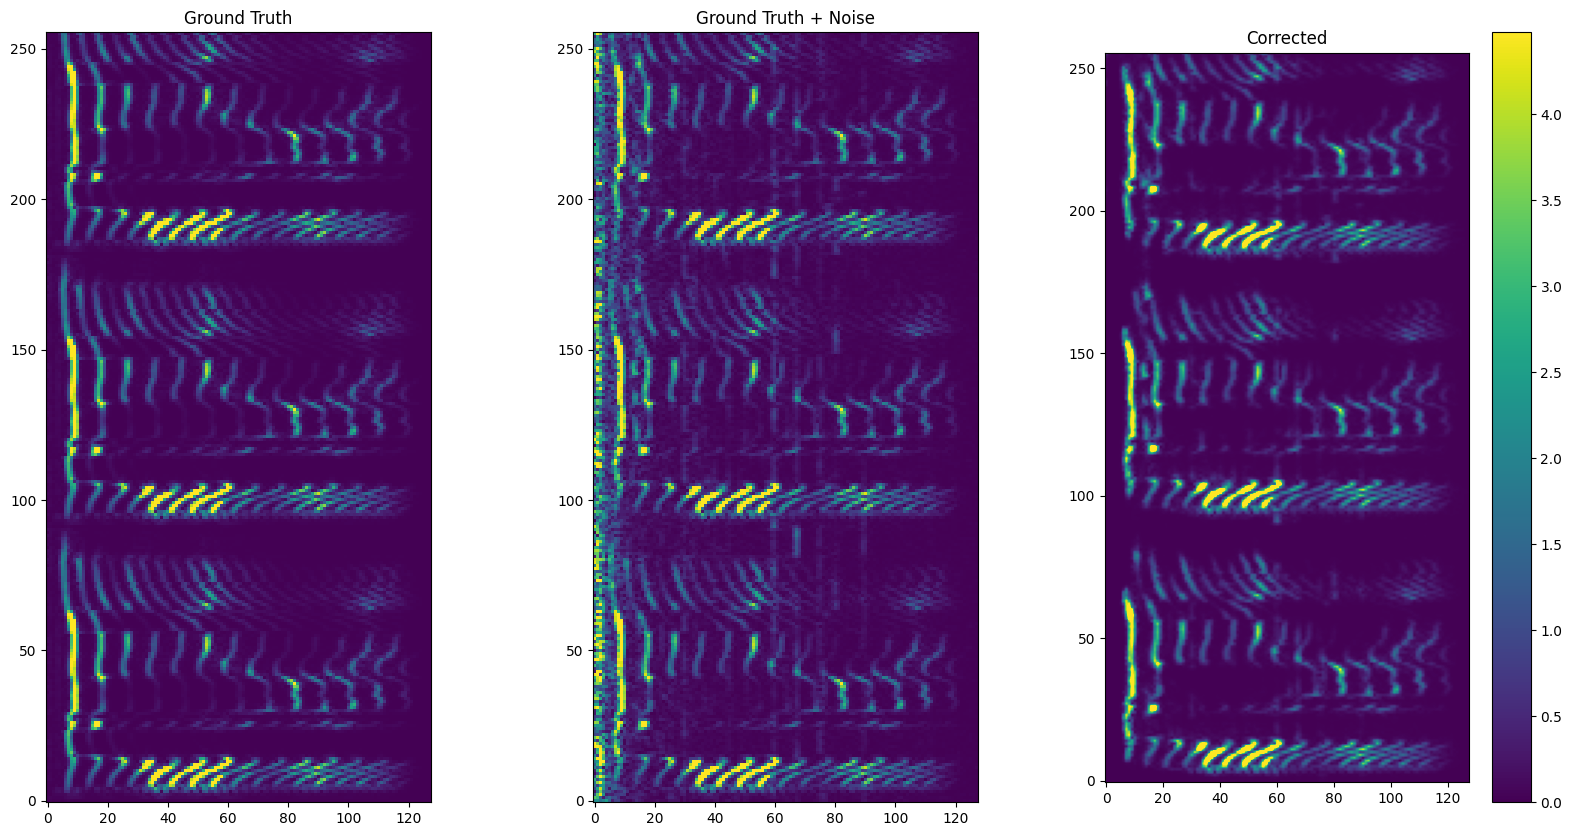

In [56]:
ind = melhor_ind_corrupt
fig,axes = plt.subplots(ncols=3,figsize=(20,10))
vmax=spec_clean_array[ind].max()/3
vmin=0
plt.subplot(1,3,1)
plt.title('Ground Truth')
plt.imshow(spec_clean_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,2)
plt.title('Ground Truth + Noise')
plt.imshow(spec_corrupt_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,3)
plt.title('Corrected')
plt.imshow(spec_correct_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.colorbar()

# Pior Índice

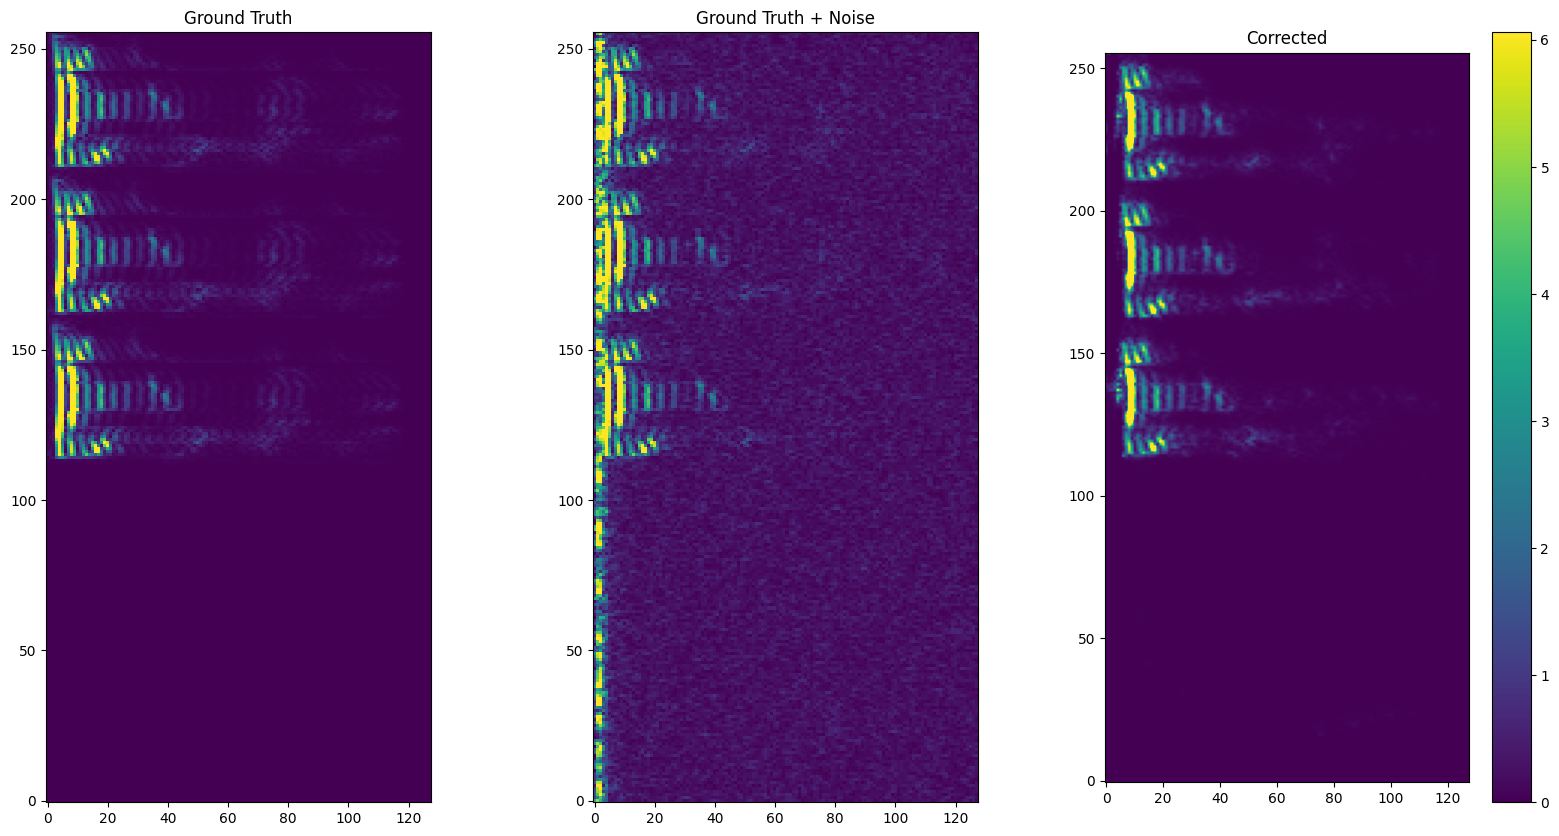

In [57]:
ind = pior_ind_corrupt
fig,axes = plt.subplots(ncols=3,figsize=(20,10))
vmax=spec_clean_array[ind].max()/3
vmin=0
plt.subplot(1,3,1)
plt.title('Ground Truth')
plt.imshow(spec_clean_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,2)
plt.title('Ground Truth + Noise')
plt.imshow(spec_corrupt_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,3)
plt.title('Corrected')
plt.imshow(spec_correct_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.colorbar()


In [ ]:
!rm -r val_results

In [ ]:
results_dir = 'val_results'
os.mkdir(results_dir)

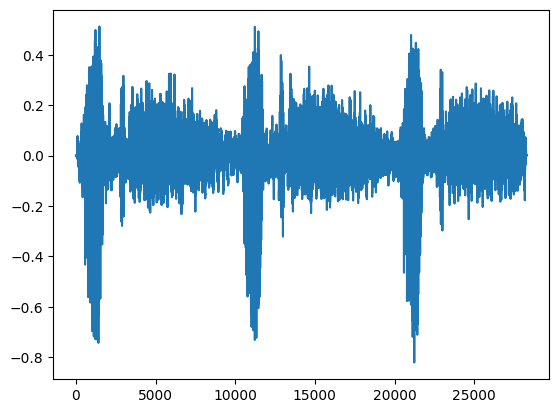

In [59]:
plt.plot(wav_corrupt_array[melhor_ind_corrupt])
Audio(wav_corrupt_array[melhor_ind_corrupt],rate=sr)

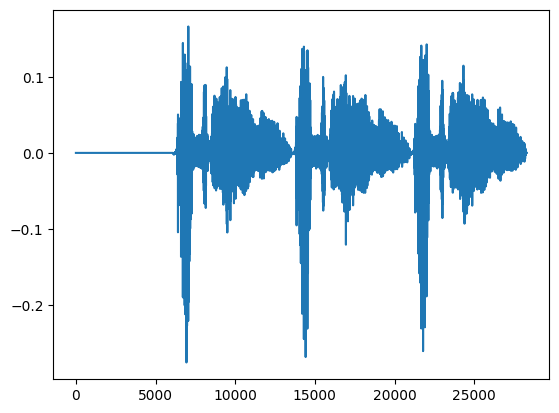

In [58]:
plt.plot(wav_clean_array[melhor_ind_correct])
Audio(wav_clean_array[melhor_ind_correct],rate=sr)

In [ ]:
plt.plot(wav_correct_array[ind])
Audio(wav_correct_array[ind],rate=sr)

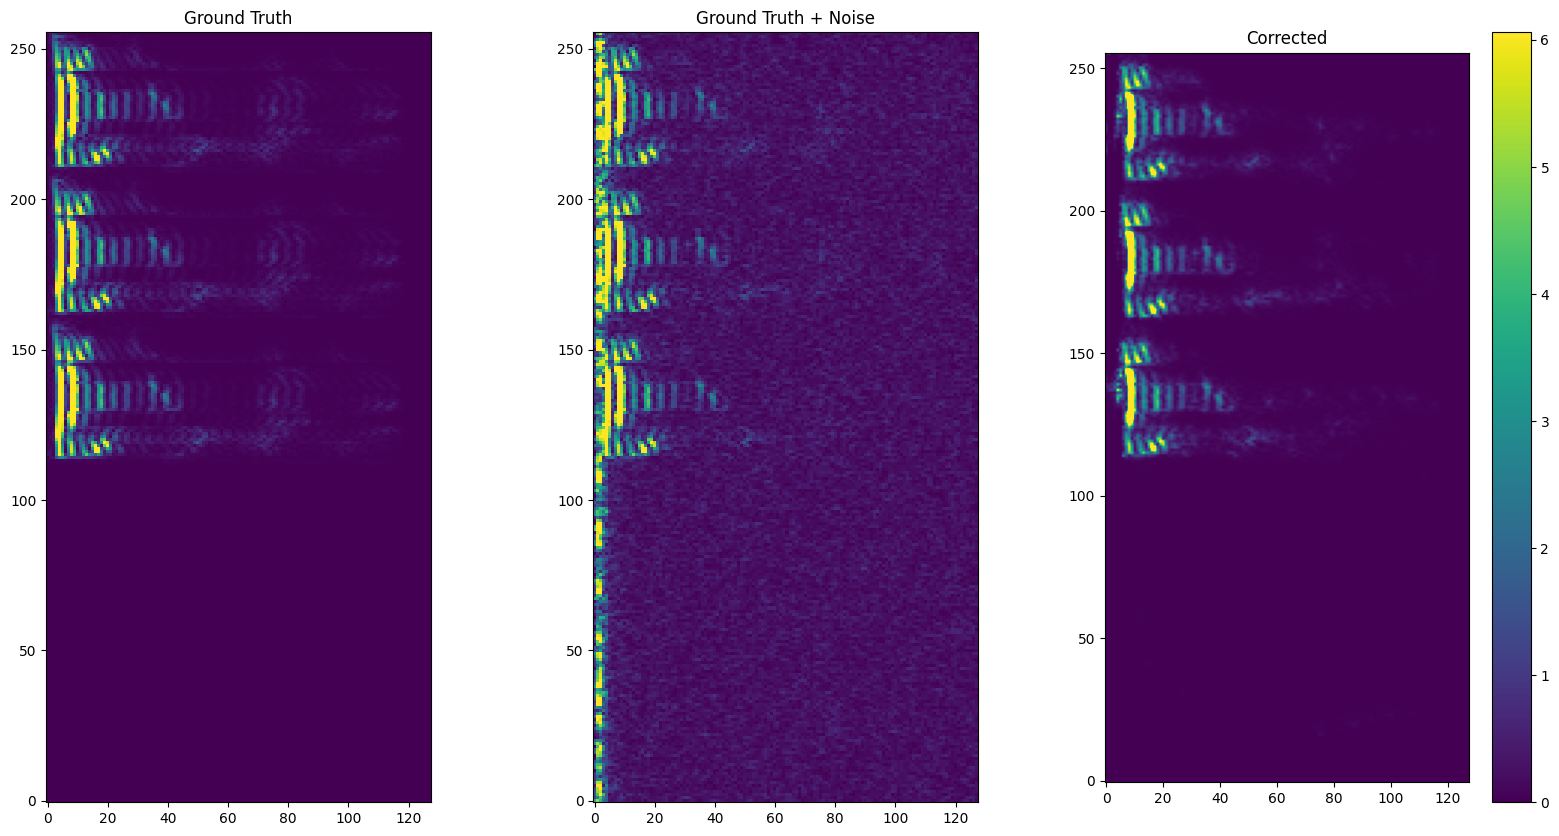

In [60]:
fig,axes = plt.subplots(ncols=3,figsize=(20,10))
vmax=spec_clean_array[ind].max()/3
vmin=0
plt.subplot(1,3,1)
plt.title('Ground Truth')
plt.imshow(spec_clean_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,2)
plt.title('Ground Truth + Noise')
plt.imshow(spec_corrupt_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.subplot(1,3,3)
plt.title('Corrected')
plt.imshow(spec_correct_array[ind], origin='lower',vmax=vmax,vmin=vmin)
plt.colorbar()